# Evaluation of simulation measurements
* Generate measurements with OMNeT++
* Convert them to csv using `scavetool` (done below)
* Read and analyze using Python

For more details see this tutorial: https://docs.omnetpp.org/tutorials/pandas/

Evaluated service: Video streaming service with ad insertion

![omnet](../docs/omnet.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import call
%matplotlib inline

In [2]:
# call scavetool to generate the CSV
!{'scavetool x ../omnet-test/results/*.vec -o measurements.csv'}

Exported 190 vectors


In [3]:
# convenience functions for parsing numbers and arrays in csv correctly
def parse_if_number(s):
    try: 
        return float(s)
    except: 
        return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

# load measurements from results folder
results = pd.read_csv('measurements.csv', converters = {
                    'attrvalue': parse_if_number,
                    'binedges': parse_ndarray,
                    'binvalues': parse_ndarray,
                    'vectime': parse_ndarray,
                    'vecvalue': parse_ndarray})
results.head()

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
0,VideoFixed-1-20180806-08:32:41-14428,runattr,NaN,NaN,configname,VideoFixed,NaN,None,None
1,VideoFixed-1-20180806-08:32:41-14428,runattr,NaN,NaN,datetime,20180806-08:32:41,NaN,None,None
2,VideoFixed-1-20180806-08:32:41-14428,runattr,NaN,NaN,experiment,VideoFixed,NaN,None,None
3,VideoFixed-1-20180806-08:32:41-14428,runattr,NaN,NaN,inifile,omnetpp.ini,NaN,None,None
4,VideoFixed-1-20180806-08:32:41-14428,runattr,NaN,NaN,iterationvars,"$0=""0.6 0.4""",NaN,None,None


In [41]:
# return transformed data frame only containing the recorded vectors
# replace run number with the corresponding parameter values, saved as iterationvars
def vectors(results):
    # select matching parameters per row based on 'run' 
    itervars = results[results.attrname == 'iterationvars'] 
    params = []
    for index, row in results.iterrows():
        params.append(itervars.loc[itervars.run == row.run].iloc[0].attrvalue)
       
    # add param column
    results['param'] = pd.Series(params, index=results.index)
    
    # return filtered results (only vectors, only relevant columns)
    return pd.DataFrame(data=results[results.type == 'vector'], columns=['module', 'name', 'vectime', 'vecvalue', 'param'])
        
vecs = vectors(results)
vecs.head()

,module,name,vectime,vecvalue,param
145,VideoFixed.U_T0,processingDelay,"[0.0, 0.795874504566, 1.69443489305, 2.6176580...","[0.79587450456578, 0.89856038848394, 0.9232231...","$0=""0.5 0.5"""
146,VideoFixed.C_T3,queueLength0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","$0=""0.5 0.5"""
147,VideoFixed.C_T3,queueLength1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","$0=""0.5 0.5"""
148,VideoFixed.S_T0,queueLength0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","$0=""0.5 0.5"""
149,VideoFixed.V_T0,queueLength0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","$0=""0.5 0.5"""


In [61]:
# return df with separate rows for each vector element of vec_name (columns module, param, time, <vec_name>)
# select only rows of 'only_modules'
def vector_values(vectors, vec_name, only_modules=None):
    vec_values = {'module': [], 'hit_ratio': [], 'time': [], vec_name: []}
    selected_vecs = vectors[vectors['name'] == vec_name]
    for index, row in selected_vecs.iterrows():     
        # unroll vector into separate rows
        if only_modules is None or row['module'][11:] in only_modules:               
            for i in range(row['vectime'].size):
                vec_values['module'].append(row['module'][11:])    # drop "VideoFixed." prefix
                vec_values['hit_ratio'].append(row['param'][4:-5])     # transform '$0="0.7 0.3"' into '0.7'
                vec_values['time'].append(row['vectime'][i])
                vec_values[vec_name].append(row['vecvalue'][i])
            
    return pd.DataFrame(data=vec_values)

## Impact of cache hit ratio on end-to-end delay

In [62]:
# get tokenInDelays but only at user U_P0
end2end_delays = vector_values(vecs, 'tokenInDelay', only_modules=['U_P0'])
end2end_delays.tail()

,module,hit_ratio,time,tokenInDelay
15635,U_P0,0.9,3590.704079,0.015134
15636,U_P0,0.9,3598.193271,1.165319
15637,U_P0,0.9,3598.248748,0.951804
15638,U_P0,0.9,3598.513639,0.253359
15639,U_P0,0.9,3599.775268,0.769844


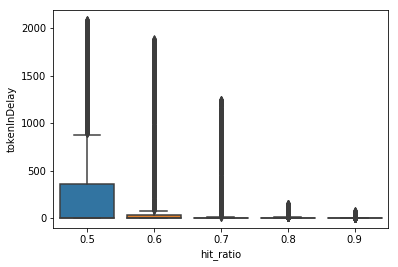

In [64]:
# plot boxplots for different cache hit ratios
# cache misses lead to much higher delays and significant outliers
sns.boxplot('hit_ratio', 'tokenInDelay', data=end2end_delays)

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


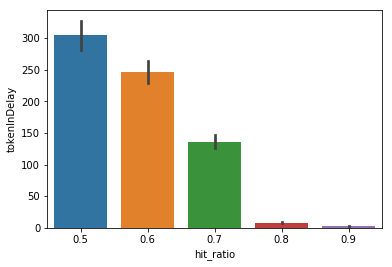

In [71]:
# barplot with mean
from numpy import mean

sns.barplot('hit_ratio', 'tokenInDelay', data=end2end_delays, estimator=mean)

c:\users\stefan\git-repos\work\venv\qpn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


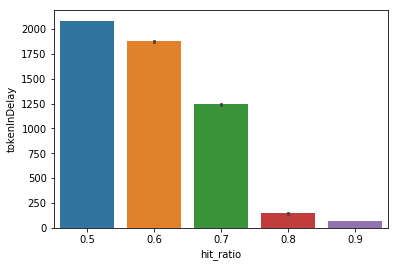

In [74]:
# barplot with max delay
sns.barplot('hit_ratio', 'tokenInDelay', data=end2end_delays, estimator=max)

## Analysis of max. supported rate

## Bottleneck identification

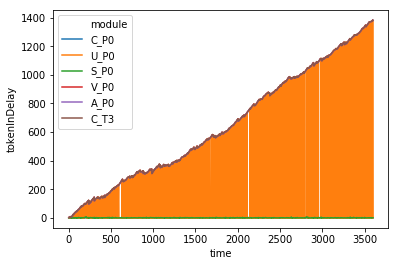

In [39]:
# shows increasing delay at VNFs after server and at user
sns.lineplot('time', 'tokenInDelay', hue='module', data=delays)
# TODO: improve visibility; plot queue lengths